See the competition here [AIcrowd Insurance Competition](https://www.aicrowd.com/challenges/insurance-pricing-game)

In [1]:
import gc
import time
import os

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import csv
import pickle
from tqdm import tqdm
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, ElasticNet

from hyperopt import hp, STATUS_OK, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
lgb.__version__

'2.3.1'

### Read in the data

In [3]:
df = pd.read_csv('data/training.csv')
print(f"The shape of data is {df.shape}")
df.head()

The shape of data is (228216, 26)


id_policy  year  pol_no_claims_discount pol_coverage  pol_duration  \
0  PL000000   1.0                   0.332         Med2             5   
1  PL042495   1.0                   0.000         Med2             6   
2  PL042496   1.0                   0.196         Med1             2   
3  PL042497   1.0                   0.000         Med2             8   
4  PL042498   1.0                   0.000         Med1             2   

   pol_sit_duration pol_pay_freq pol_payd    pol_usage drv_sex1  drv_age1  \
0                 1      Monthly       No  WorkPrivate        M      35.0   
1                 1      Monthly       No  WorkPrivate        M      60.0   
2                 1       Yearly      Yes      Retired        M      55.0   
3                 5       Yearly       No  WorkPrivate        F      54.0   
4                 2       Yearly       No      Retired        F      65.0   

   drv_age_lic1 drv_drv2 drv_sex2  drv_age2  drv_age_lic2     vh_make_model  \
0          16.0      Yes        F      26.0           1.0  aparvvfowrjncdhp   
1          41.0       No        0       NaN           NaN  aparvvfowrjncdhp   
2          35.0      Yes        F      57.0          38.0  iwhqpdfuhrsxyqxe   
3          31.0       No        0       NaN           NaN  kvcddisqpkysmvvo   
4          38.0       No        0       NaN           NaN  tdgkjlphosocwbgu   

   vh_age   vh_fuel     vh_type  vh_speed  vh_value  vh_weight  population  \
0     8.0  Gasoline     Tourism     174.0   11040.0     1143.0      1270.0   
1    10.0    Diesel     Tourism     174.0   11040.0     1143.0      1290.0   
2     8.0    Diesel  Commercial     150.0   14159.0     1193.0      1020.0   
3     4.0  Gasoline     Tourism     149.0   17233.0     1012.0       180.0   
4    13.0  Gasoline     Tourism     200.0   19422.0     1315.0        30.0   

   town_surface_area  claim_amount  
0               33.1           0.0  
1               51.3           0.0  
2              262.8           0.0  
3              219.7           0.0  
4               70.3           0.0

In [4]:
X_train = df.drop(columns=['claim_amount'])
y_train = df['claim_amount']

In [5]:
print(f"Number of unique id_policy {X_train['id_policy'].nunique()} and number of years {X_train['year'].unique()}")

Number of unique id_policy 57054 and number of years [1. 2. 3. 4.]


In [6]:
print(f"Number of missing values \n {X_train.isnull().sum().sort_values(ascending = False)}")

Number of missing values 
 drv_age_lic2              152896
drv_age2                  152896
vh_weight                   2552
vh_value                    2552
vh_speed                    2552
vh_age                         4
town_surface_area              0
pol_usage                      0
year                           0
pol_no_claims_discount         0
pol_coverage                   0
pol_duration                   0
pol_sit_duration               0
pol_pay_freq                   0
pol_payd                       0
drv_drv2                       0
drv_sex1                       0
drv_age1                       0
drv_age_lic1                   0
population                     0
drv_sex2                       0
vh_make_model                  0
vh_fuel                        0
vh_type                        0
id_policy                      0
dtype: int64


In [7]:
print(f"Percentage of non zero claims {(y_train != 0).sum()/(y_train == 0).sum()*100}")

Percentage of non zero claims 11.366165017274698


### Feature engineering

In [8]:
X_train['population_density'] = X_train['population']/X_train['town_surface_area']

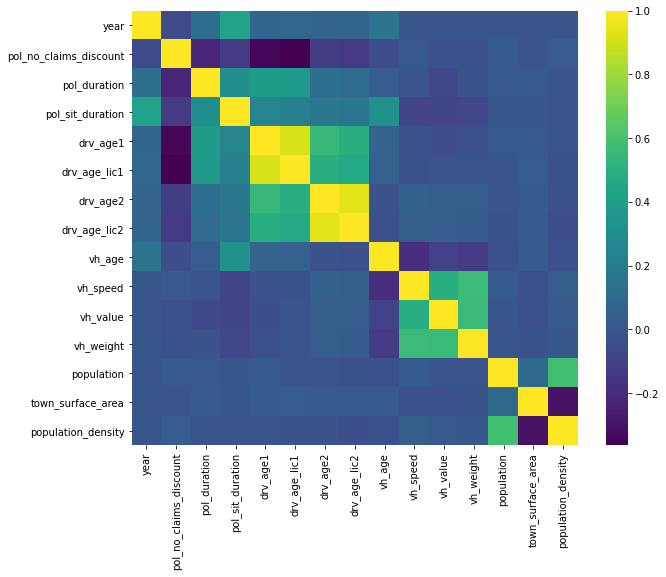

In [9]:
# calculate the correlation matrix
corr = X_train.corr()

# plot the heatmap

plt.figure(figsize = (10, 8))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = 'viridis')

In [10]:
all_features = list(X_train.columns)

In [11]:
modelling_features = [
                         'id_policy',
                         'year',
                         'pol_no_claims_discount',
                         'pol_coverage',
                         'pol_duration',
                         'pol_sit_duration',
                         'pol_pay_freq',
                         'pol_payd',
                         'pol_usage',
                         'drv_sex1',
                         'drv_age1',
                         'drv_age_lic1',
                         'drv_drv2',
                         'drv_sex2',
                         'drv_age2',
                         'drv_age_lic2',
                         'vh_make_model',
                         'vh_age',
                         'vh_fuel',
                         'vh_type',
                         'vh_speed',
                         'vh_value',
                         'vh_weight',
                         'population',
                         'town_surface_area',
                       #  'population_density'
                     ]

### Preprocess data

In [12]:
def preprocess_X_data(X, label_encoder = True, features = modelling_features):
    
    # defining the cleaned data
    X_clean = X.copy()
    
    #variables to be imputed 
    imp_var = ['vh_weight', 'vh_value', 'vh_speed', 'vh_age']

    # impute missing values by median
    for var in imp_var:
        X_clean[var]  = X_clean[var].fillna(np.ceil(X_clean[var].median()))
        
    if label_encoder:
        
        #get the cat features
        cat_features = [c for c in X_clean.columns if X_clean[c].dtypes == 'O']
        
        print(f"Label encode the categorical features {cat_features}")
        
        for cat in cat_features:
            le = LabelEncoder()
            le.fit(X_clean[cat])
            X_clean[cat] = le.transform(X_clean[cat])
            
    X_clean = X_clean[features]
  
    return X_clean

In [13]:
X_clean = preprocess_X_data(X_train)
X_clean.info()

Label encode the categorical features ['id_policy', 'pol_coverage', 'pol_pay_freq', 'pol_payd', 'pol_usage', 'drv_sex1', 'drv_drv2', 'drv_sex2', 'vh_make_model', 'vh_fuel', 'vh_type']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  int64  
 1   year                    228216 non-null  float64
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  int64  
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  int64  
 7   pol_payd                228216 non-null  int64  
 8   pol_usage               228216 non-null  int64  
 9   drv_sex1                228216 non-null  int64  
 10  drv_age1                228216 non-null  float64
 11

In [14]:
#split into modelling and validation sets
X_model = X_clean[X_clean['year'] < 4].reset_index(drop=True)
y_model = df.loc[df['year']< 4, 'claim_amount'].reset_index(drop=True)
X_val = X_clean[X_clean['year'] == 4].reset_index(drop=True)
y_val = df.loc[df['year'] == 4, 'claim_amount'].reset_index(drop=True)
print(f"X_model shape is {X_model.shape}")
print(f"X_val shape is {X_val.shape}")

X_model shape is (171162, 25)
X_val shape is (57054, 25)


### Baseline lgb model

In [15]:
#prepare datasets for lgb 
train_set = lgb.Dataset(X_model, y_model)
val_set = lgb.Dataset(X_val, y_val)

In [16]:
#train the model 
params = {'seed': 42, 
          'metric': 'rmse', 
          'objective': 'tweedie',
          'boosting_type': 'goss',
          'nthread': 10} #use the default params, only specify seed and metric
ts = time.time()
lgb_model = lgb.train(params = params, train_set=train_set, valid_sets = [val_set], 
                verbose_eval = 1, early_stopping_rounds = 20,
                num_boost_round = 1000)
print(f'lgb model finishes in {time.time()-ts}')

[1]	valid_0's rmse: 829.406
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 829.023
[3]	valid_0's rmse: 828.707
[4]	valid_0's rmse: 828.483
[5]	valid_0's rmse: 828.293
[6]	valid_0's rmse: 828.135
[7]	valid_0's rmse: 828.016
[8]	valid_0's rmse: 827.907
[9]	valid_0's rmse: 827.821
[10]	valid_0's rmse: 827.75
[11]	valid_0's rmse: 827.692
[12]	valid_0's rmse: 827.632
[13]	valid_0's rmse: 827.584
[14]	valid_0's rmse: 827.55
[15]	valid_0's rmse: 827.532
[16]	valid_0's rmse: 827.508
[17]	valid_0's rmse: 827.465
[18]	valid_0's rmse: 827.437
[19]	valid_0's rmse: 827.411
[20]	valid_0's rmse: 827.397
[21]	valid_0's rmse: 827.381
[22]	valid_0's rmse: 827.366
[23]	valid_0's rmse: 827.36
[24]	valid_0's rmse: 827.344
[25]	valid_0's rmse: 827.347
[26]	valid_0's rmse: 827.365
[27]	valid_0's rmse: 827.359
[28]	valid_0's rmse: 827.349
[29]	valid_0's rmse: 827.34
[30]	valid_0's rmse: 827.341
[31]	valid_0's rmse: 827.352
[32]	valid_0's rmse: 827.354
[33]	valid_0's rmse: 827

In [17]:
def lgb_importance(model, X, importance_type, figsize):
    """
    importance_type is 'gain' or 'split'
    """
    feature_imp = pd.DataFrame({'Value': model.feature_importance(importance_type = importance_type), 'Feature': X.columns})
    plt.figure(figsize = figsize)
    sns.barplot(x = 'Value', y = 'Feature', data = feature_imp.sort_values(by='Value', ascending = False))
    plt.title('LightGBM feature importance')
    plt.tight_layout()

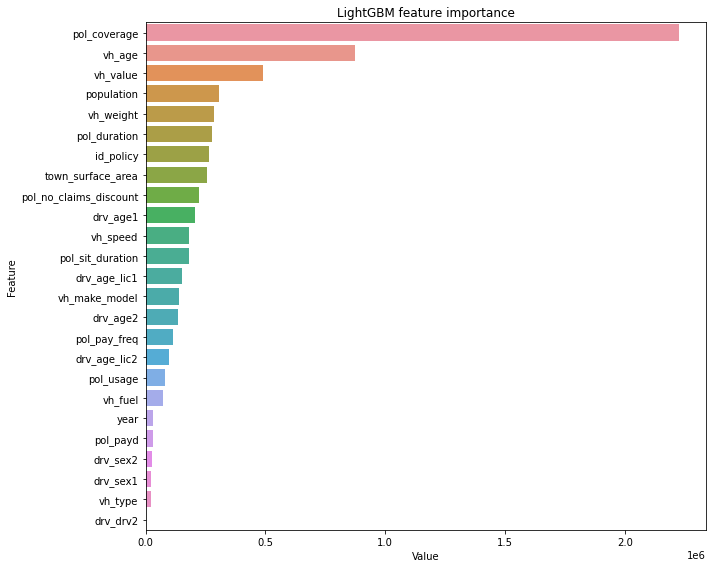

In [18]:
lgb_importance(lgb_model, X_model, 'gain', (10,8))

### Bayesian optimization for lightgbm

In [19]:
lgb_space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']),
    'objective': hp.choice('objective', ['regression', 'tweedie']),
    'num_leaves': hp.choice('num_leaves', np.arange(30,150, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.choice('subsample_for_bin', np.arange(20000,300000, 20000, dtype = int)),
    'min_child_samples': hp.choice('min_child_samples', np.arange(20,500,5, dtype = int)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'seed': 42,
    'nthread': 10,
    'num_boost_round': 1000,
    'early_stopping_rounds': 20,
    'metric': 'rmse',
    'vebose_eval': 1
}

In [20]:
def bayesian_opt(space, model, train_set, val_set, num_boost_round, early_stopping_rounds, random_seed, 
                 MAX_EVALS = 100, out_file = None, trials = None, mode = 'loss_cost', metric = 'rmse'):
    
    """
    out_file (str): location of the grid search file
    trials (str): location of the bayes trials
    """
    
    if not out_file:
        #create the output folder if it does not exist
        if not os.path.exists('output'):
            os.makedirs('output')
        #create the grid search file
        out_file = f'output/{model}_{mode}_trials.csv'
        of_connection = open(out_file, 'w')
        writer = csv.writer(of_connection)
        writer.writerow(['loss', 'params', 'n_estimators', 'train_time'])
        of_connection.close()
        
    if not trials:
        #create the trial object
        bayes_trials = Trials()
    else:
        bayes_trials = pickle.load(open(trials, 'rb'))
        
    #if model == 'lgb':
        
    def objective(params):

        ts = time.time()

        train_model = eval(model).train(params, train_set, num_boost_round, val_set, early_stopping_rounds = early_stopping_rounds)

        run_time = time.time()-ts

        if model == 'lgb':
        
            #extract the best score
            loss = train_model.best_score['valid_0'][metric]

            #extract the best number of iterators
            n_estimators = train_model.best_iteration
        elif model == 'xgb':
            
            #extract the best score
            loss = train_model.best_score

            #extract the best number of iterators
            n_estimators = train_model.best_iteration + 1
            

        #write to the csv file ('a' means append)
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, n_estimators, run_time ])

        return {'loss' : loss, 'params':params, 'n_estimators': n_estimators, 
               'train_time': run_time, 'status': STATUS_OK}  
        
    #run hyperopt
    fmin(fn = objective, space = space, algo = tpe.suggest,  max_evals = MAX_EVALS, trials = bayes_trials,
        rstate = np.random.RandomState(random_seed))

    #save trial object
    pickle.dump(bayes_trials, open(f'output/{model}_{mode}_bayes_trials.pickle', 'wb'))

    return bayes_trials 

In [21]:
#run 100 models
#bayesian_opt(lgb_space, 'lgb', train_set, val_set,1000, 20, 42, 100)

In [22]:
#continue gs 
#bayesian_opt(lgb_space, 'lgb', train_set, val_set,1000, 20, 42, 25000, 'output/lgb_trials.csv', 'output/lgb_bayes_trials.pickle')

Read in the gs results

In [23]:
def read_csv(path, ascending = True):
    
    gs = pd.read_csv(path)
    #sort by increasing loss
    gs.sort_values('loss', inplace = True, ascending = ascending)
    gs.reset_index(inplace = True, drop = True)
    
    #create a new dataframe for storing parameters
    gs_df = pd.DataFrame(columns = list(eval(gs.loc[0,'params']).keys()),
                                index = list(range(len(gs))))

    #add the results with each parameter a different column
    for i, params in enumerate(gs['params']):
        gs_df.loc[i,:] = list(eval(params).values())

    gs_df['loss'] = gs['loss']
    gs_df['n_estimators'] = gs['n_estimators']

    return gs_df

In [24]:
bayes_params = read_csv('output/lgb_trials.csv')
print(f'We have {bayes_params.shape[0]} models')
bayes_params.head(10)

We have 25000 models


boosting_type colsample_bytree early_stopping_rounds learning_rate metric  \
0          goss         0.649851                    20      0.165013   rmse   
1          goss         0.642913                    20      0.159329   rmse   
2          goss         0.646707                    20       0.16964   rmse   
3          goss         0.617274                    20      0.155957   rmse   
4          goss         0.630499                    20       0.13217   rmse   
5          goss          0.62187                    20      0.145285   rmse   
6          goss         0.691458                    20      0.189354   rmse   
7          goss         0.674742                    20      0.176462   rmse   
8          goss         0.656113                    20       0.13066   rmse   
9          goss         0.635746                    20      0.156524   rmse   

  min_child_samples nthread num_boost_round num_leaves objective reg_alpha  \
0               465      10            1000         60   tweedie  0.969921   
1               240      10            1000         58   tweedie  0.981809   
2               280      10            1000         48   tweedie  0.872371   
3               430      10            1000         45   tweedie  0.849912   
4                95      10            1000        118   tweedie  0.888249   
5               235      10            1000        143   tweedie  0.944638   
6               485      10            1000        113   tweedie   0.88831   
7               355      10            1000         43   tweedie  0.873346   
8               445      10            1000         77   tweedie  0.933035   
9               420      10            1000         82   tweedie  0.888754   

  reg_lambda seed subsample subsample_for_bin vebose_eval        loss  \
0   0.623498   42  0.528959            120000           1  826.844353   
1   0.432143   42  0.500319             40000           1  826.908614   
2   0.627936   42  0.500001             40000           1  826.935523   
3   0.586005   42  0.833924            220000           1  826.957167   
4    0.28099   42  0.775076             40000           1  826.964435   
5   0.708463   42  0.516275             80000           1  826.965701   
6   0.502314   42  0.761201            200000           1  826.972951   
7   0.417877   42  0.606371            180000           1  826.976644   
8   0.635351   42  0.548807            260000           1  826.979144   
9   0.645991   42  0.531279            220000           1  826.987392   

   n_estimators  
0            57  
1            46  
2            24  
3            36  
4            22  
5            42  
6            31  
7            41  
8            29  
9            47

In [25]:
bayes_params.loc[0,:]

boosting_type                goss
colsample_bytree         0.649851
early_stopping_rounds          20
learning_rate            0.165013
metric                       rmse
min_child_samples             465
nthread                        10
num_boost_round              1000
num_leaves                     60
objective                 tweedie
reg_alpha                0.969921
reg_lambda               0.623498
seed                           42
subsample                0.528959
subsample_for_bin          120000
vebose_eval                     1
loss                      826.844
n_estimators                   57
Name: 0, dtype: object

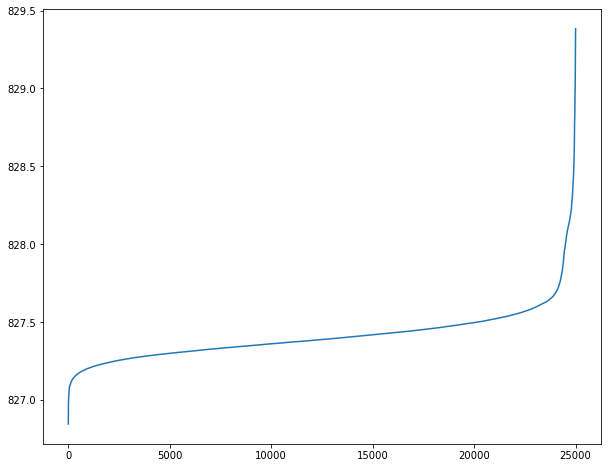

In [26]:
#plot the loss
plt.figure(figsize = (10,8)) 
plt.plot(bayes_params['loss'])

Text(0.5, 1.0, 'Learning Rate distribution')

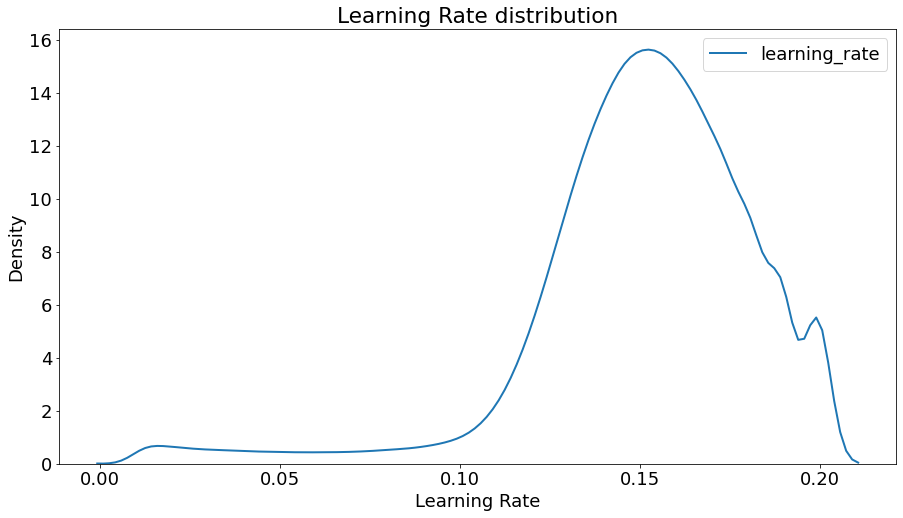

In [27]:
#learning rate 
plt.figure(figsize = (15,8))
plt.rcParams['font.size'] = 18

#Density plots of the learning rate distribution 
sns.kdeplot(bayes_params['learning_rate'], linewidth = 2)
plt.xlabel('Learning Rate')
plt.ylabel('Density')
plt.title('Learning Rate distribution')

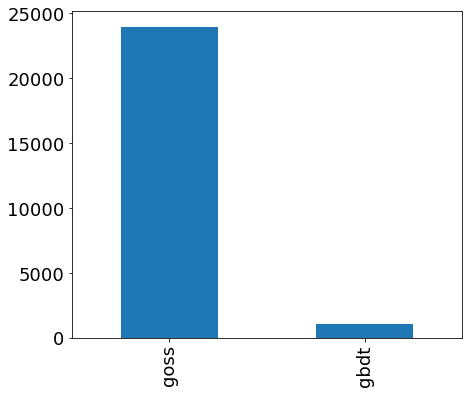

In [28]:
#plot boosting type
bayes_params['boosting_type'].value_counts().plot.bar(figsize = (7,6))

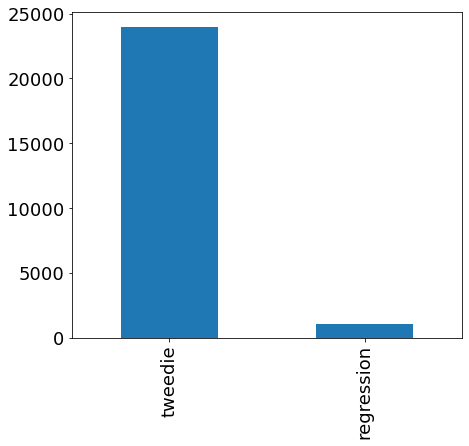

In [29]:
#plot objective
bayes_params['objective'].value_counts().plot.bar(figsize = (7,6))

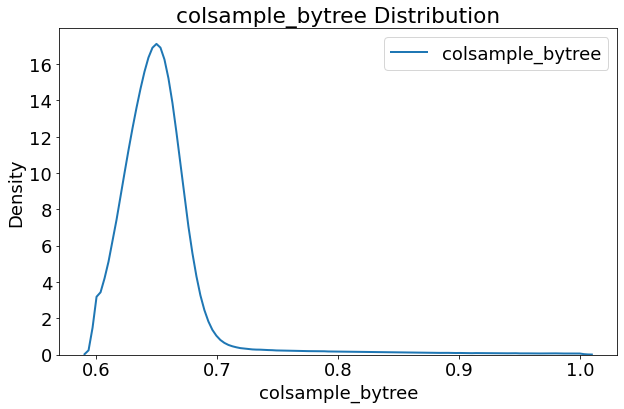

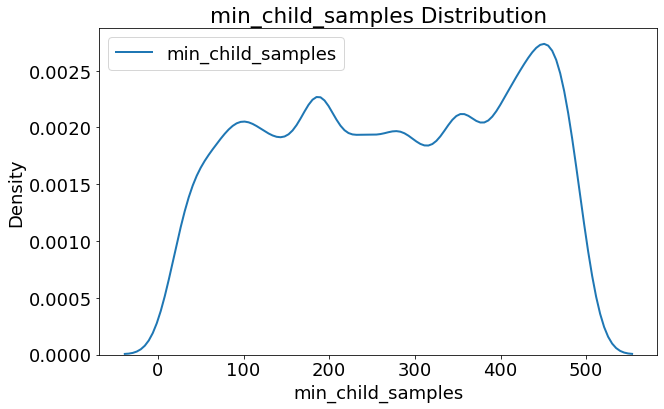

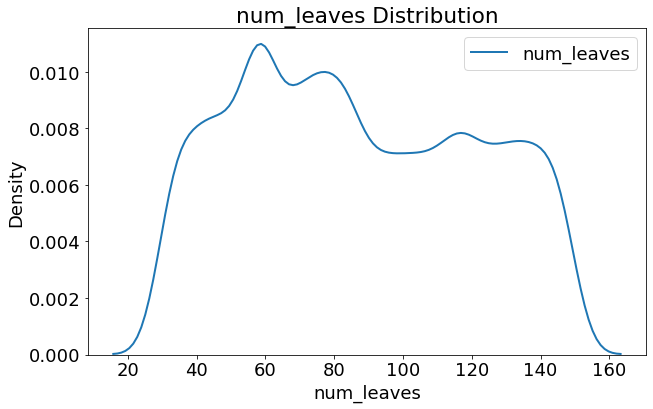

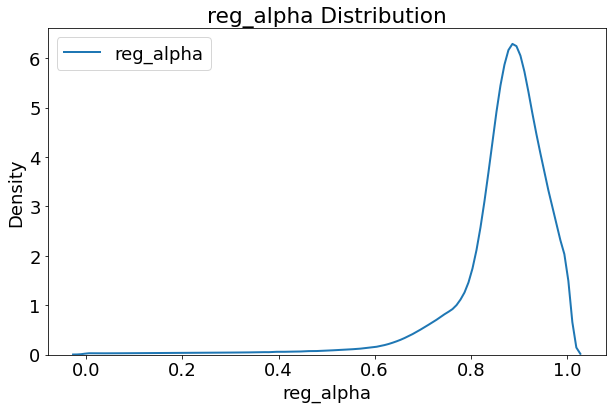

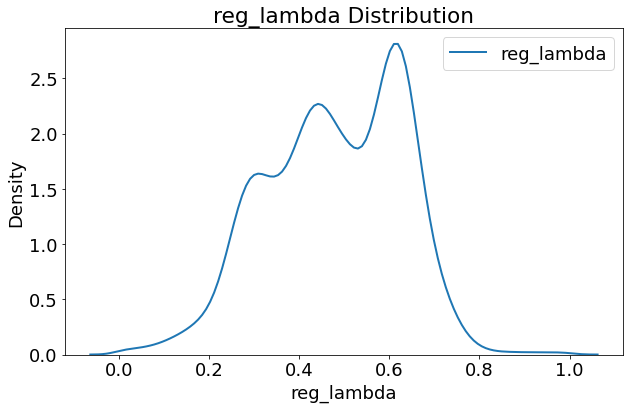

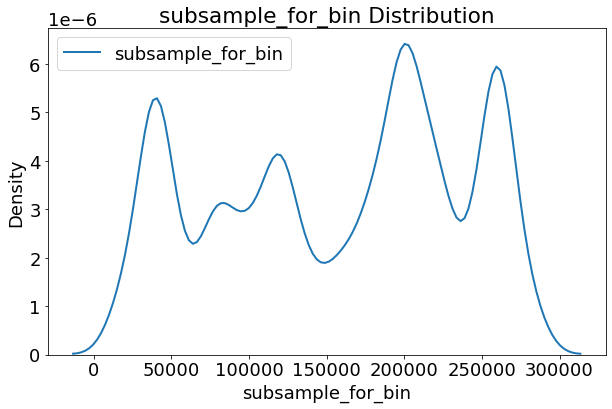

In [30]:
#iterate through each numeric hyperparameters
for hyper in ['colsample_bytree', 'min_child_samples', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample_for_bin']:
    plt.figure(figsize = (10,6))
    sns.kdeplot(bayes_params[hyper], linewidth = 2)
    plt.xlabel('{}'.format(hyper))
    plt.ylabel('Density')
    plt.title('{} Distribution'.format(hyper))

In [31]:
#evaluate best result
lgb_gs = pd.read_csv('output/lgb_trials.csv')
lgb_gs.sort_values('loss', inplace = True)
lgb_gs.reset_index(inplace = True, drop = True)

best_bayes_estimators = lgb_gs.loc[3, 'n_estimators']
best_bayes_params = eval(lgb_gs.loc[3,'params'])
best_bayes_params['num_boost_round'] = best_bayes_estimators

#fit the best model on the whole train data
all_data = lgb.Dataset(X_clean, y_train)
best_lgb_model = lgb.train(params = best_bayes_params, train_set=train_set, valid_sets = [train_set, val_set])

[1]	training's rmse: 685.788	valid_1's rmse: 829.275
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 685.031	valid_1's rmse: 828.754
[3]	training's rmse: 684.434	valid_1's rmse: 828.362
[4]	training's rmse: 684.147	valid_1's rmse: 828.216
[5]	training's rmse: 683.743	valid_1's rmse: 828.02
[6]	training's rmse: 683.453	valid_1's rmse: 827.926
[7]	training's rmse: 683.129	valid_1's rmse: 827.715
[8]	training's rmse: 682.854	valid_1's rmse: 827.56
[9]	training's rmse: 682.619	valid_1's rmse: 827.482
[10]	training's rmse: 682.38	valid_1's rmse: 827.401
[11]	training's rmse: 682.171	valid_1's rmse: 827.354
[12]	training's rmse: 681.96	valid_1's rmse: 827.325
[13]	training's rmse: 681.751	valid_1's rmse: 827.282
[14]	training's rmse: 681.563	valid_1's rmse: 827.219
[15]	training's rmse: 681.358	valid_1's rmse: 827.227
[16]	training's rmse: 681.178	valid_1's rmse: 827.2
[17]	training's rmse: 680.974	valid_1's rmse: 827.192
[18]	training's rmse: 680.777	valid_

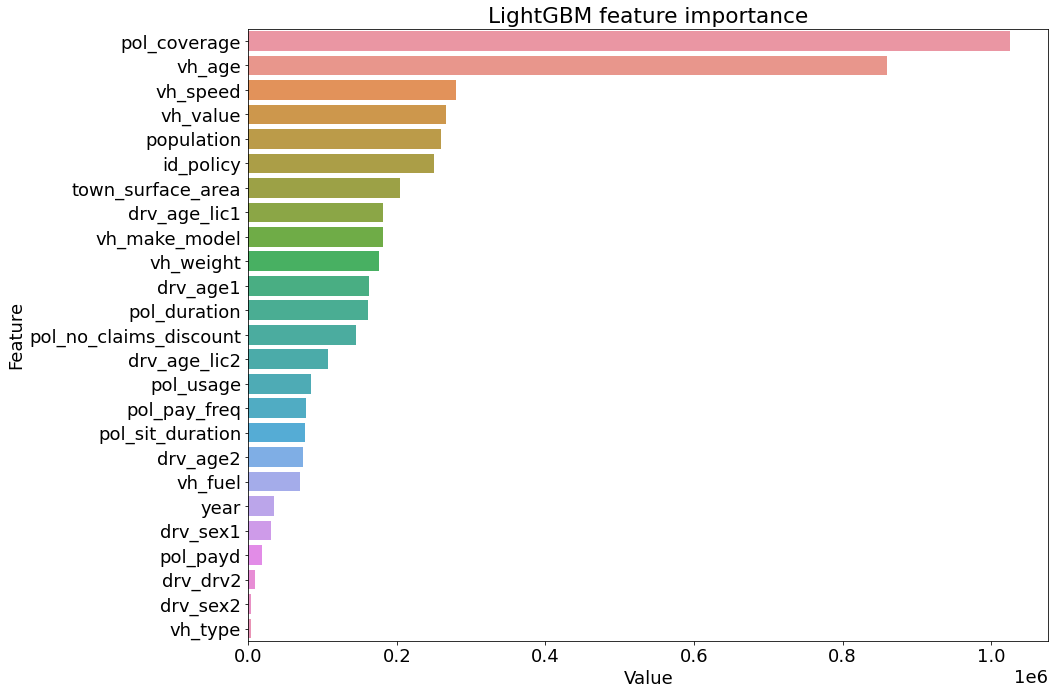

In [32]:
lgb_importance(best_lgb_model, X_model, 'gain', (15,10))

### Linear ensemble lightgbm

In [33]:
best_bayes_params = {
    'boosting_type': 'goss',
     'colsample_bytree': 0.6172740422553246,
     'early_stopping_rounds': 20,
     'learning_rate': 0.15595728874144082,
     'metric': 'rmse',
     'min_child_samples': 430,
     'nthread': 10,
     'num_boost_round': 36,
     'num_leaves': 45,
     'objective': 'tweedie',
     'reg_alpha': 0.8499119497868239,
     'reg_lambda': 0.5860052343438305,
     'seed': 42,
     'subsample': 0.8339240170542691,
     'subsample_for_bin': 220000,
     'vebose_eval': 1
}

In [34]:
#create a dictionary of lightgbm models based on seeds
seeds = [42, 123, 34, 2021, 7]
seed_models = {}

for seed in seeds:
    best_bayes_params['seed'] = seed
    lgb_model = lgb.train(params = best_bayes_params, train_set=train_set, valid_sets = [train_set, val_set])
    seed_models[seed] = lgb_model

[1]	training's rmse: 685.788	valid_1's rmse: 829.275
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 685.031	valid_1's rmse: 828.754
[3]	training's rmse: 684.434	valid_1's rmse: 828.362
[4]	training's rmse: 684.147	valid_1's rmse: 828.216
[5]	training's rmse: 683.743	valid_1's rmse: 828.02
[6]	training's rmse: 683.453	valid_1's rmse: 827.926
[7]	training's rmse: 683.129	valid_1's rmse: 827.715
[8]	training's rmse: 682.854	valid_1's rmse: 827.56
[9]	training's rmse: 682.619	valid_1's rmse: 827.482
[10]	training's rmse: 682.38	valid_1's rmse: 827.401
[11]	training's rmse: 682.171	valid_1's rmse: 827.354
[12]	training's rmse: 681.96	valid_1's rmse: 827.325
[13]	training's rmse: 681.751	valid_1's rmse: 827.282
[14]	training's rmse: 681.563	valid_1's rmse: 827.219
[15]	training's rmse: 681.358	valid_1's rmse: 827.227
[16]	training's rmse: 681.178	valid_1's rmse: 827.2
[17]	training's rmse: 680.974	valid_1's rmse: 827.192
[18]	training's rmse: 680.777	valid_

[28]	training's rmse: 678.661	valid_1's rmse: 827.539
[29]	training's rmse: 678.467	valid_1's rmse: 827.526
[30]	training's rmse: 678.273	valid_1's rmse: 827.525
[31]	training's rmse: 678.037	valid_1's rmse: 827.55
[32]	training's rmse: 677.865	valid_1's rmse: 827.532
[33]	training's rmse: 677.604	valid_1's rmse: 827.53
[34]	training's rmse: 677.414	valid_1's rmse: 827.541
[35]	training's rmse: 677.136	valid_1's rmse: 827.551
[36]	training's rmse: 676.969	valid_1's rmse: 827.557
Did not meet early stopping. Best iteration is:
[36]	training's rmse: 676.969	valid_1's rmse: 827.557


In [35]:
#now do predictions
train_preds = {}
val_preds = {}
for seed in seeds:
    lgb_model = seed_models[seed]
    train_preds[f"lgb_{seed}"] = lgb_model.predict(X_model)
    val_preds[f"lgb_{seed}"] = lgb_model.predict(X_val)
    
L0_train = pd.DataFrame(train_preds)
L0_val = pd.DataFrame(val_preds)

In [36]:
L0_train.head()

lgb_42     lgb_123      lgb_34    lgb_2021       lgb_7
0  120.233421  145.590455  111.882966  142.433576  110.918455
1   66.937509   52.135866   60.471744   71.142985   60.881417
2   67.313945  103.806294  109.365541   94.748503   89.544737
3   49.304198   65.539242   70.200592   52.251082   53.714275
4   53.112922   33.365004   68.495844   47.454739   48.985937

In [37]:
L0_val.head()

lgb_42     lgb_123      lgb_34    lgb_2021       lgb_7
0   57.072316   68.904113   56.595976   44.380953   55.276487
1   71.066250   63.277413   57.222888   63.610851   61.209302
2   59.517957   90.979370   90.479704  100.047324   76.360634
3   48.077927   35.650198   40.358060   33.566808   32.038215
4  139.740880  103.199037  158.695273  182.613207  133.100588

#### Fit a linear regression on L0 predictions

In [38]:
lr = LinearRegression()
lr.fit(L0_train, y_model)
L1_preds = lr.predict(L0_val)
print(f"The rmse of stacking model is {np.sqrt(mean_squared_error(L1_preds, y_val))}")

The rmse of stacking model is 837.6439981496621


In [39]:
#simply taking the average
L1_preds = L0_val.mean(axis = 1)
print(f"The rmse of stacking model is {np.sqrt(mean_squared_error(L1_preds, y_val))}")

The rmse of stacking model is 827.1946764144643


### Output prediction plots

In [40]:
best_bayes_params = {
    'boosting_type': 'goss',
     'colsample_bytree': 0.6172740422553246,
     'early_stopping_rounds': 20,
     'learning_rate': 0.15595728874144082,
     'metric': 'rmse',
     'min_child_samples': 430,
     'nthread': 10,
     'num_boost_round': 36,
     'num_leaves': 45,
     'objective': 'tweedie',
     'reg_alpha': 0.8499119497868239,
     'reg_lambda': 0.5860052343438305,
     'seed': 42,
     'subsample': 0.8339240170542691,
     'subsample_for_bin': 220000,
     'vebose_eval': 1
}

In [41]:
lgb_model = lgb.train(params = best_bayes_params, train_set=train_set, valid_sets = [train_set, val_set])

[1]	training's rmse: 685.788	valid_1's rmse: 829.275
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 685.031	valid_1's rmse: 828.754
[3]	training's rmse: 684.434	valid_1's rmse: 828.362
[4]	training's rmse: 684.147	valid_1's rmse: 828.216
[5]	training's rmse: 683.743	valid_1's rmse: 828.02
[6]	training's rmse: 683.453	valid_1's rmse: 827.926
[7]	training's rmse: 683.129	valid_1's rmse: 827.715
[8]	training's rmse: 682.854	valid_1's rmse: 827.56
[9]	training's rmse: 682.619	valid_1's rmse: 827.482
[10]	training's rmse: 682.38	valid_1's rmse: 827.401
[11]	training's rmse: 682.171	valid_1's rmse: 827.354
[12]	training's rmse: 681.96	valid_1's rmse: 827.325
[13]	training's rmse: 681.751	valid_1's rmse: 827.282
[14]	training's rmse: 681.563	valid_1's rmse: 827.219
[15]	training's rmse: 681.358	valid_1's rmse: 827.227
[16]	training's rmse: 681.178	valid_1's rmse: 827.2
[17]	training's rmse: 680.974	valid_1's rmse: 827.192
[18]	training's rmse: 680.777	valid_

In [42]:
preds_train = lgb_model.predict(X_model)
preds_val = lgb_model.predict(X_val)

In [43]:
X_model_plot = X_model.copy()
X_val_plot = X_val.copy()
X_model_plot['predictions'] = preds_train
X_val_plot['predictions'] = preds_val
X_model_plot['target'] = y_model
X_val_plot['target'] = y_val

In [44]:
plot_features = [
    #'id_policy',
     'year',
     'pol_no_claims_discount',
     'pol_coverage',
     'pol_duration',
     'pol_sit_duration',
     'pol_pay_freq',
     'pol_payd',
     'pol_usage',
     'drv_sex1',
     'drv_age1',
     'drv_age_lic1',
     'drv_drv2',
     'drv_sex2',
     'drv_age2',
     'drv_age_lic2',
     #'vh_make_model',
     'vh_age',
     'vh_fuel',
     'vh_type',
     #'vh_speed',
     #'vh_value',
     #'vh_weight',
     #'population',
     #'town_surface_area'
]

In [45]:
for feat in plot_features:
    X_model_feat = X_model_plot.groupby(feat).agg({'target':'mean', 'predictions': 'mean'}).reset_index()
    fig = px.line(X_model_feat, x=feat, y=['predictions', 'target'])
    fig.show()

In [46]:
for feat in plot_features:
    X_val_feat = X_val_plot.groupby(feat).agg({'target':'mean', 'predictions': 'mean'}).reset_index()
    fig = px.line(X_val_feat, x=feat, y=['predictions', 'target'])
    fig.show()

### Ensemble the top 5 models

In [47]:
lgb_gs = pd.read_csv('output/lgb_trials.csv')
lgb_gs.sort_values('loss', inplace = True)
lgb_gs.reset_index(inplace = True, drop = True)

In [51]:
best_bayes_estimators = lgb_gs.loc[3, 'n_estimators']
best_bayes_params = eval(lgb_gs.loc[3,'params'])
best_bayes_params['num_boost_round'] = best_bayes_estimators
best_bayes_params

{'boosting_type': 'goss',
 'colsample_bytree': 0.6172740422553246,
 'early_stopping_rounds': 20,
 'learning_rate': 0.15595728874144082,
 'metric': 'rmse',
 'min_child_samples': 430,
 'nthread': 10,
 'num_boost_round': 36,
 'num_leaves': 45,
 'objective': 'tweedie',
 'reg_alpha': 0.8499119497868239,
 'reg_lambda': 0.5860052343438305,
 'seed': 42,
 'subsample': 0.8339240170542691,
 'subsample_for_bin': 220000,
 'vebose_eval': 1}

In [68]:
n = 5

In [69]:
train_preds = {}
val_preds = {}

for i in range(n):
    best_bayes_estimators = lgb_gs.loc[i, 'n_estimators']
    best_bayes_params = eval(lgb_gs.loc[i,'params'])
    best_bayes_params['num_boost_round'] = best_bayes_estimators
    
    lgb_model = lgb.train(params = best_bayes_params, train_set=train_set, valid_sets = [train_set, val_set])
    train_preds[f"lgb_model_{i}"] = lgb_model.predict(X_model)
    val_preds[f"lgb_model_{i}"] = lgb_model.predict(X_val)
    
L0_train = pd.DataFrame(train_preds)
L0_val = pd.DataFrame(val_preds)

[1]	training's rmse: 685.704	valid_1's rmse: 829.246
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 684.877	valid_1's rmse: 828.709
[3]	training's rmse: 684.235	valid_1's rmse: 828.323
[4]	training's rmse: 683.892	valid_1's rmse: 828.161
[5]	training's rmse: 683.399	valid_1's rmse: 827.902
[6]	training's rmse: 683.078	valid_1's rmse: 827.797
[7]	training's rmse: 682.709	valid_1's rmse: 827.622
[8]	training's rmse: 682.362	valid_1's rmse: 827.535
[9]	training's rmse: 682.057	valid_1's rmse: 827.485
[10]	training's rmse: 681.752	valid_1's rmse: 827.389
[11]	training's rmse: 681.468	valid_1's rmse: 827.343
[12]	training's rmse: 681.213	valid_1's rmse: 827.328
[13]	training's rmse: 680.965	valid_1's rmse: 827.326
[14]	training's rmse: 680.757	valid_1's rmse: 827.28
[15]	training's rmse: 680.525	valid_1's rmse: 827.228
[16]	training's rmse: 680.278	valid_1's rmse: 827.165
[17]	training's rmse: 680.035	valid_1's rmse: 827.102
[18]	training's rmse: 679.781	v

[1]	training's rmse: 685.709	valid_1's rmse: 829.384
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 684.828	valid_1's rmse: 828.882
[3]	training's rmse: 684.083	valid_1's rmse: 828.518
[4]	training's rmse: 683.563	valid_1's rmse: 828.335
[5]	training's rmse: 682.933	valid_1's rmse: 828.105
[6]	training's rmse: 682.414	valid_1's rmse: 828.009
[7]	training's rmse: 681.782	valid_1's rmse: 827.809
[8]	training's rmse: 681.296	valid_1's rmse: 827.668
[9]	training's rmse: 680.782	valid_1's rmse: 827.61
[10]	training's rmse: 680.268	valid_1's rmse: 827.517
[11]	training's rmse: 679.774	valid_1's rmse: 827.482
[12]	training's rmse: 679.293	valid_1's rmse: 827.379
[13]	training's rmse: 678.832	valid_1's rmse: 827.337
[14]	training's rmse: 678.333	valid_1's rmse: 827.248
[15]	training's rmse: 677.837	valid_1's rmse: 827.247
[16]	training's rmse: 677.337	valid_1's rmse: 827.228
[17]	training's rmse: 676.655	valid_1's rmse: 827.126
[18]	training's rmse: 676.215	v

In [70]:
L0_train.head()

lgb_model_0  lgb_model_1  lgb_model_2  lgb_model_3  lgb_model_4
0   162.930181   186.374062   103.941453   120.233421    81.403562
1    60.936725    55.968175    60.187218    66.937509    56.099019
2    51.221401    52.206474    79.652876    67.313945    60.559313
3    42.819593    39.722283    48.661080    49.304198    56.862711
4    34.365207    35.046520    46.897614    53.112922    37.047395

In [71]:
L0_val.head()

lgb_model_0  lgb_model_1  lgb_model_2  lgb_model_3  lgb_model_4
0    60.973766    62.272614    56.295400    57.072316    58.679235
1    42.087358    42.003328    73.075681    71.066250    60.431015
2    54.071608    93.327986    59.435560    59.517957    78.783428
3    26.204329    41.690225    31.059495    48.077927    30.330590
4   148.250614   192.330022   130.958091   139.740880   108.779631

In [72]:
L1_preds = L0_val.mean(axis = 1)
print(f"The rmse of stacking model is {np.sqrt(mean_squared_error(L1_preds, y_val))}")

The rmse of stacking model is 826.6980903728662


### Bayesian optimization XGBoost

In [33]:
xgb_space = {
    'objective': hp.choice('objective', ['reg:squarederror', 'reg:tweedie']),
    'max_depth': hp.choice('max_depth', np.arange(4,15, dtype = int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(20,500,5, dtype = int)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate':  hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'gamma': hp.uniform('gamma', 0, 2.5),
    'seed': 42,
    'nthread': 13,
    'early_stopping_rounds': 20,
    #'tree_method': 'gpu_hist', #remove this if do not want to use gpu
    'eval_metric': 'rmse',
    'verbose_eval': 0
}

In [34]:
#prepare datasets for xgb
train_set_xgb = xgb.DMatrix(X_model, y_model)
val_set_xgb = xgb.DMatrix(X_val, y_val)

In [35]:
#run 100 models
#bayesian_opt(xgb_space, 'xgb', train_set_xgb, [(train_set_xgb, 'train'), (val_set_xgb, 'val')] , 1000, 20, 42, 100)

In [36]:
#continue gs 
#bayesian_opt(xgb_space, 'xgb', train_set_xgb, [(train_set_xgb, 'val'), (val_set_xgb, 'val')] ,1000, 20, 42, 1000, 'output/xgb_loss_cost_trials.csv', 'output/xgb_loss_cost_bayes_trials.pickle')

In [37]:
bayes_params_xgb = read_csv('output/xgb_loss_cost_trials.csv')
print(f'We have {bayes_params_xgb.shape[0]} models')
bayes_params_xgb.head()

We have 1000 models


colsample_bytree early_stopping_rounds eval_metric     gamma learning_rate  \
0         0.732632                    20        rmse  0.636488     0.0495583   
1         0.761145                    20        rmse  0.734648     0.0424047   
2         0.770398                    20        rmse  0.700991     0.0300328   
3         0.611366                    20        rmse  0.539638     0.0568423   
4         0.777606                    20        rmse   2.32077     0.0560644   

  max_depth min_child_weight nthread    objective reg_alpha   reg_lambda seed  \
0         4              470      13  reg:tweedie  0.915038     0.415892   42   
1         4              290      13  reg:tweedie  0.892473  0.000229743   42   
2         4              335      13  reg:tweedie  0.840991    0.0231886   42   
3         4              255      13  reg:tweedie  0.917163     0.376143   42   
4         4              100      13  reg:tweedie  0.895578     0.151021   42   

  subsample verbose_eval        loss  n_estimators  
0  0.530496            0  827.170166           230  
1  0.524687            0  827.188965           230  
2   0.50056            0  827.191345           312  
3  0.502322            0  827.191467           205  
4  0.531303            0  827.193665           137

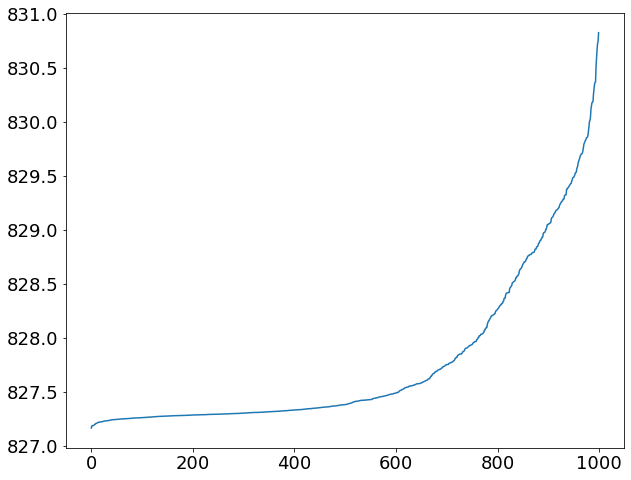

In [38]:
#plot the loss
plt.figure(figsize = (10,8)) 
plt.plot(bayes_params_xgb['loss'])

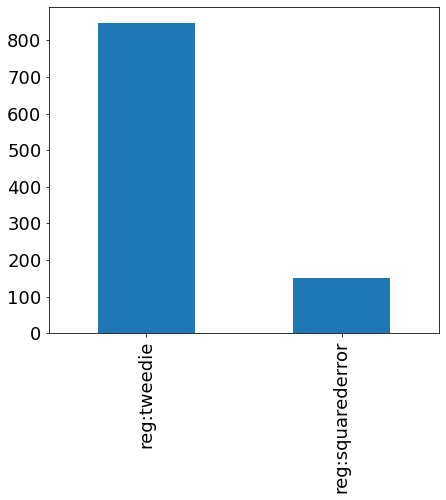

In [39]:
#plot objective
bayes_params_xgb['objective'].value_counts().plot.bar(figsize = (7,6))

In [40]:
#evaluate best result
xgb_gs = pd.read_csv('output/xgb_loss_cost_trials.csv')
xgb_gs.sort_values('loss', inplace = True)
xgb_gs.reset_index(inplace = True, drop = True)

best_bayes_estimators_xgb = xgb_gs.loc[0, 'n_estimators']
best_bayes_params_xgb = eval(xgb_gs.loc[0,'params'])
best_bayes_params_xgb['num_boost_round'] = best_bayes_estimators_xgb

print(f"Use params {best_bayes_params_xgb} \n")

#fit the best model on the whole train data
print("BEGIN TRAINING")
best_xgb_model = xgb.train(best_bayes_params_xgb, train_set_xgb, num_boost_round = best_bayes_estimators_xgb, 
                           evals = [(train_set_xgb,'train'), (val_set_xgb, 'validation')])

Use params {'colsample_bytree': 0.7326323266013696, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'gamma': 0.6364878999736042, 'learning_rate': 0.04955834926839291, 'max_depth': 4, 'min_child_weight': 470, 'nthread': 13, 'objective': 'reg:tweedie', 'reg_alpha': 0.9150383999448207, 'reg_lambda': 0.4158916305804351, 'seed': 42, 'subsample': 0.5304963105566902, 'verbose_eval': 0, 'num_boost_round': 230} 

BEGIN TRAINING
[08:32:02] WARNING: /workspace/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_boost_round, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:696.42987	validation-rmse:836.55164
[1]	train-rmse:696.42041	validation-rmse:836.54443
[2]	train-rmse:696.40979	validation-rmse:836.53656
[3]	train-rmse:696.39832	validation-rmse

[142]	train-rmse:679.66687	validation-rmse:827.27313
[143]	train-rmse:679.66754	validation-rmse:827.27356
[144]	train-rmse:679.75360	validation-rmse:827.27692
[145]	train-rmse:679.74029	validation-rmse:827.27673
[146]	train-rmse:679.72296	validation-rmse:827.27704
[147]	train-rmse:679.71435	validation-rmse:827.27942
[148]	train-rmse:679.71545	validation-rmse:827.27356
[149]	train-rmse:679.53156	validation-rmse:827.27411
[150]	train-rmse:679.55292	validation-rmse:827.27753
[151]	train-rmse:679.54218	validation-rmse:827.27734
[152]	train-rmse:679.50732	validation-rmse:827.26715
[153]	train-rmse:679.45398	validation-rmse:827.26312
[154]	train-rmse:679.40478	validation-rmse:827.26941
[155]	train-rmse:679.38275	validation-rmse:827.27179
[156]	train-rmse:679.31958	validation-rmse:827.27154
[157]	train-rmse:679.29858	validation-rmse:827.26251
[158]	train-rmse:679.28589	validation-rmse:827.26086
[159]	train-rmse:679.24194	validation-rmse:827.25232
[160]	train-rmse:679.17242	validation-rmse:827

In [41]:
def xgb_importance(model, importance_type, figsize):
    """
    importance_type is 'gain' or 'weight' or 'cover' or 'total_gain' or 'total_cover'
    """
    feature_imp = pd.DataFrame({'Value': list(model.get_score(importance_type = importance_type).values()), 'Feature': list(model.get_score(importance_type=importance_type).keys())})
    plt.figure(figsize = figsize)
    sns.barplot(x = 'Value', y = 'Feature', data = feature_imp.sort_values(by='Value', ascending = False))
    plt.title('XgBoost feature importance')
    plt.tight_layout()

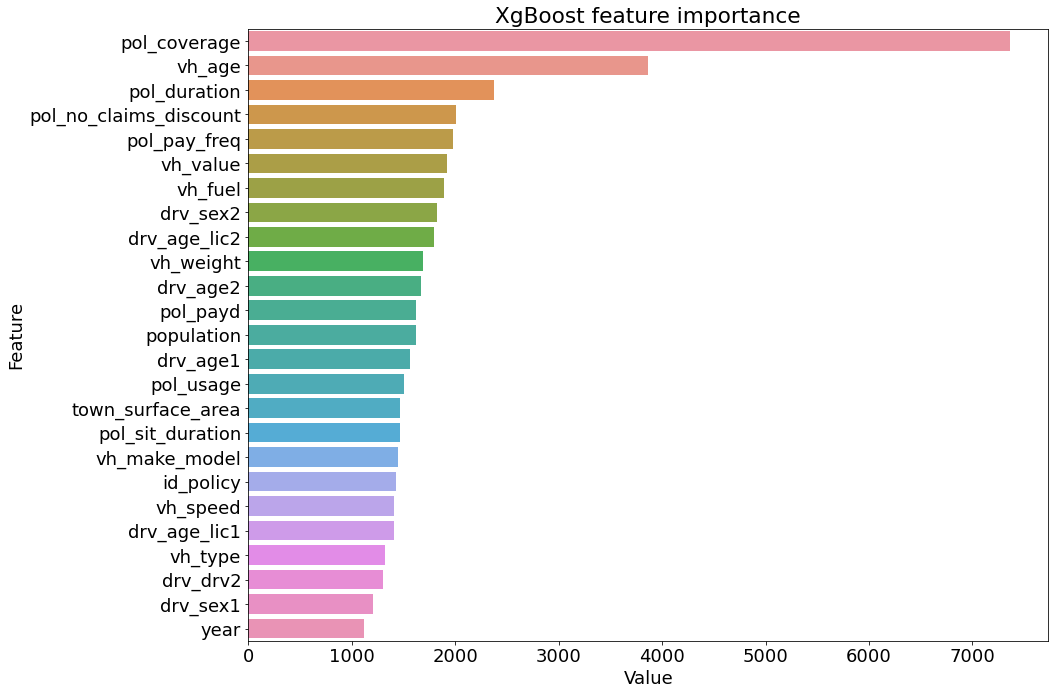

In [42]:
xgb_importance(best_xgb_model, 'gain', (15,10))

### Frequency model

In [43]:
y_model_freq = (y_model > 0).astype(int)
y_val_freq = (y_val > 0).astype(int)
print(f"The number of nonzero claims in modelling data is {y_model_freq.sum()}")
print(f"The number of nonzero claims in validation data is {y_val_freq.sum()}")

The number of nonzero claims in modelling data is 18057
The number of nonzero claims in validation data is 5235


In [44]:
#prepare datasets for lgb 
train_set_freq = lgb.Dataset(X_model, y_model_freq)
val_set_freq = lgb.Dataset(X_val, y_val_freq)

In [45]:
lgb_space_freq = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']),
    'objective': hp.choice('objective', ['binary', 'poisson']),
    'num_leaves': hp.choice('num_leaves', np.arange(30,150, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.choice('subsample_for_bin', np.arange(20000,300000, 20000, dtype = int)),
    'min_child_samples': hp.choice('min_child_samples', np.arange(20,500,5, dtype = int)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'seed': 42,
    'nthread': 10,
    'num_boost_round': 1000,
    'early_stopping_rounds': 20,
    'metric': 'auc',
    'vebose_eval': 1
}

In [46]:
#run 100 models
#bayesian_opt(lgb_space_freq, 'lgb', train_set_freq, val_set_freq, 1000, 20, 42, 100, mode = 'freq', metric = 'auc')

In [47]:
#continue gs
#bayesian_opt(lgb_space_freq, 'lgb', train_set_freq, val_set_freq, 1000, 20, 42, 2000, out_file='output/lgb_freq_trials.csv',
#             trials='output/lgb_freq_bayes_trials.pickle',mode = 'freq', metric = 'auc')

In [48]:
bayes_params_freq = read_csv('output/lgb_freq_trials.csv', ascending = False)
print(f'We have {bayes_params_freq.shape[0]} models')
bayes_params_freq.head()

We have 2000 models


boosting_type colsample_bytree early_stopping_rounds learning_rate metric  \
0          gbdt         0.649646                    20     0.0450004    auc   
1          gbdt          0.67822                    20     0.0335385    auc   
2          goss         0.999968                    20     0.0118232    auc   
3          goss         0.964845                    20     0.0158961    auc   
4          gbdt         0.987722                    20     0.0196753    auc   

  min_child_samples nthread num_boost_round num_leaves objective reg_alpha  \
0               235      10            1000        147    binary  0.999039   
1               350      10            1000        114   poisson  0.126552   
2               105      10            1000        125   poisson  0.928853   
3                85      10            1000        129   poisson  0.380279   
4                40      10            1000         36    binary  0.362153   

  reg_lambda seed subsample subsample_for_bin vebose_eval      loss  \
0   0.838404   42  0.814638            220000           1  0.643120   
1  0.0877639   42  0.928884            100000           1  0.642734   
2  0.0870237   42  0.914818            220000           1  0.642554   
3   0.017317   42  0.797523             40000           1  0.642310   
4  0.0307368   42  0.797672             40000           1  0.642240   

   n_estimators  
0            89  
1           219  
2           521  
3           408  
4           268

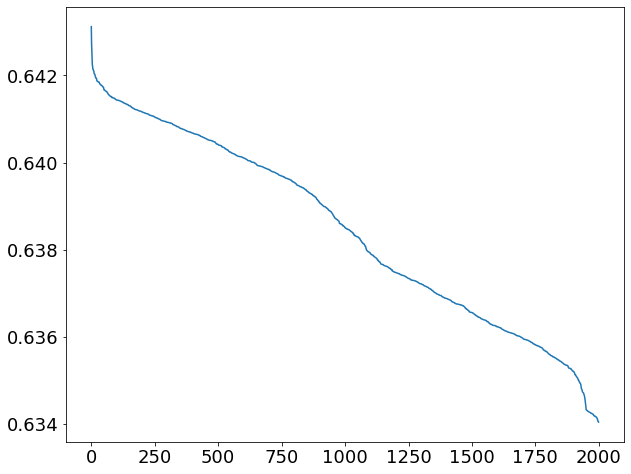

In [49]:
#plot the loss
plt.figure(figsize = (10,8)) 
plt.plot(bayes_params_freq['loss'])

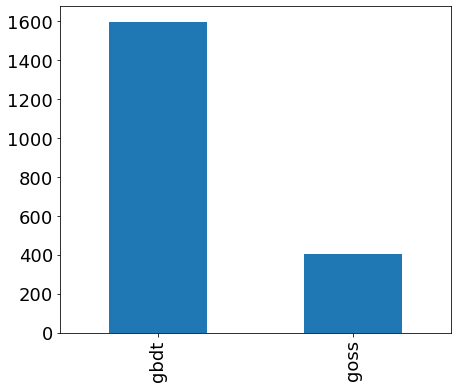

In [50]:
#plot boosting type
bayes_params_freq['boosting_type'].value_counts().plot.bar(figsize = (7,6))

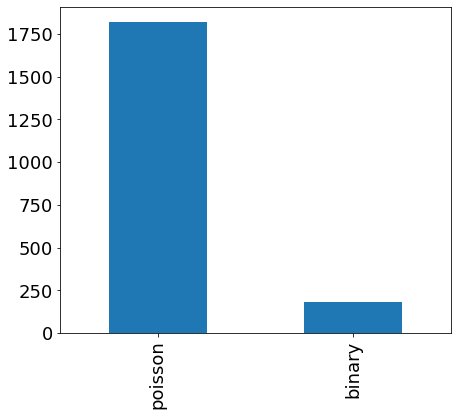

In [51]:
#plot objective
bayes_params_freq['objective'].value_counts().plot.bar(figsize = (7,6))

In [52]:
#evaluate best result
lgb_gs_freq = pd.read_csv('output/lgb_freq_trials.csv')
lgb_gs_freq.sort_values('loss', inplace = True, ascending = False)
lgb_gs_freq.reset_index(inplace = True, drop = True)

best_bayes_estimators_freq = lgb_gs_freq.loc[3, 'n_estimators']
best_bayes_params_freq = eval(lgb_gs_freq.loc[3,'params'])
best_bayes_params_freq['num_boost_round'] = best_bayes_estimators_freq

print(f"Use params {best_bayes_params_freq} \n")

#fit the best model on the whole train data
print("BEGIN TRAINING")
best_lgb_model_freq = lgb.train(params = best_bayes_params_freq, train_set=train_set_freq, 
                                valid_sets = [train_set_freq, val_set_freq])

Use params {'boosting_type': 'goss', 'colsample_bytree': 0.9648451923246854, 'early_stopping_rounds': 20, 'learning_rate': 0.015896122908068792, 'metric': 'auc', 'min_child_samples': 85, 'nthread': 10, 'num_boost_round': 408, 'num_leaves': 129, 'objective': 'poisson', 'reg_alpha': 0.3802785881105963, 'reg_lambda': 0.017317027481830907, 'seed': 42, 'subsample': 0.7975232970649452, 'subsample_for_bin': 40000, 'vebose_eval': 1} 

BEGIN TRAINING
[1]	training's auc: 0.653419	valid_1's auc: 0.627425
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.656605	valid_1's auc: 0.629617
[3]	training's auc: 0.658748	valid_1's auc: 0.631208
[4]	training's auc: 0.660348	valid_1's auc: 0.630996
[5]	training's auc: 0.66082	valid_1's auc: 0.631033
[6]	training's auc: 0.663706	valid_1's auc: 0.631919
[7]	training's auc: 0.664174	valid_1's auc: 0.632294
[8]	training's auc: 0.664283	valid_1's auc: 0.632423
[9]	training's auc: 0.664524	valid_1's auc: 0.632689
[10]	training's a

[148]	training's auc: 0.701139	valid_1's auc: 0.639367
[149]	training's auc: 0.701294	valid_1's auc: 0.639342
[150]	training's auc: 0.701494	valid_1's auc: 0.639372
[151]	training's auc: 0.701696	valid_1's auc: 0.639367
[152]	training's auc: 0.701851	valid_1's auc: 0.639389
[153]	training's auc: 0.702022	valid_1's auc: 0.639389
[154]	training's auc: 0.702215	valid_1's auc: 0.639403
[155]	training's auc: 0.702409	valid_1's auc: 0.639396
[156]	training's auc: 0.702559	valid_1's auc: 0.639449
[157]	training's auc: 0.702742	valid_1's auc: 0.63948
[158]	training's auc: 0.702932	valid_1's auc: 0.639529
[159]	training's auc: 0.703131	valid_1's auc: 0.639584
[160]	training's auc: 0.703291	valid_1's auc: 0.639641
[161]	training's auc: 0.703523	valid_1's auc: 0.639628
[162]	training's auc: 0.703677	valid_1's auc: 0.639691
[163]	training's auc: 0.703865	valid_1's auc: 0.639745
[164]	training's auc: 0.704054	valid_1's auc: 0.639728
[165]	training's auc: 0.704209	valid_1's auc: 0.639774
[166]	train

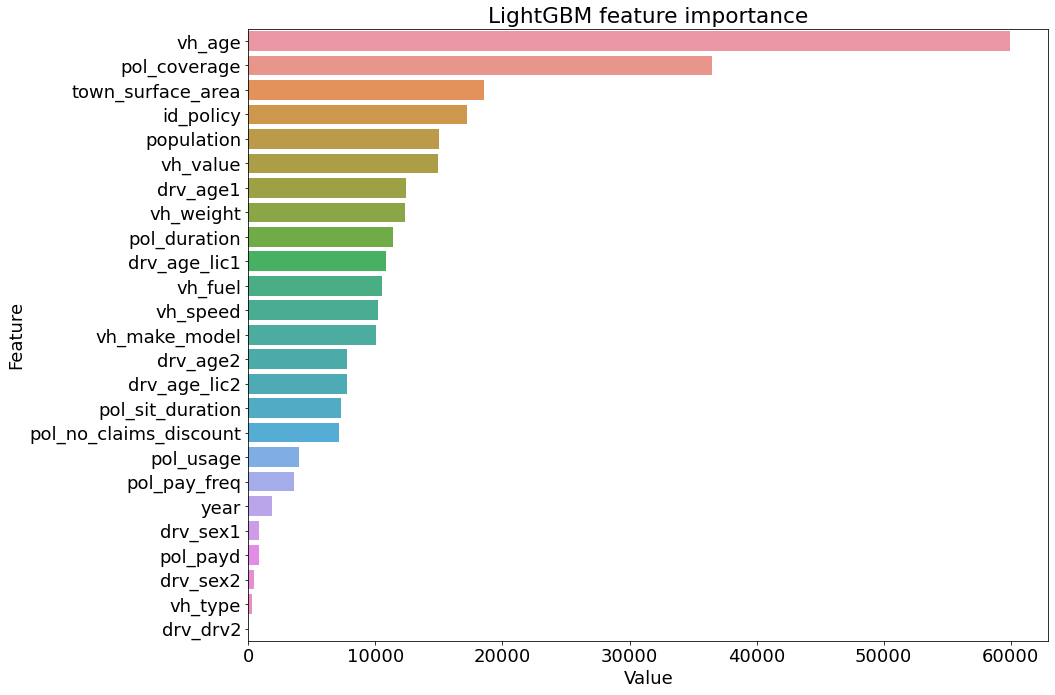

In [53]:
lgb_importance(best_lgb_model_freq, X_model, 'gain', (15,10))

### Severity model

In [54]:
#create severity dataset
X_sev = X_clean.copy()
X_sev['claim_amount'] = y_train
X_sev = X_sev[X_sev['claim_amount']>0].reset_index(drop=True)

X_train_sev = X_sev.drop('claim_amount', axis =1)
y_train_sev = X_sev['claim_amount']

#split into modelling and validation data
X_model_sev = X_train_sev[X_train_sev['year'] < 4].reset_index(drop=True)
y_model_sev = X_sev.loc[X_sev['year']< 4, 'claim_amount'].reset_index(drop=True)
X_val_sev = X_train_sev[X_train_sev['year'] == 4].reset_index(drop=True)
y_val_sev = X_sev.loc[X_sev['year'] == 4, 'claim_amount'].reset_index(drop=True)
print(f"X_model_sev shape is {X_model_sev.shape}")
print(f"X_val_sev shape is {X_val_sev.shape}")

X_model_sev shape is (18057, 25)
X_val_sev shape is (5235, 25)


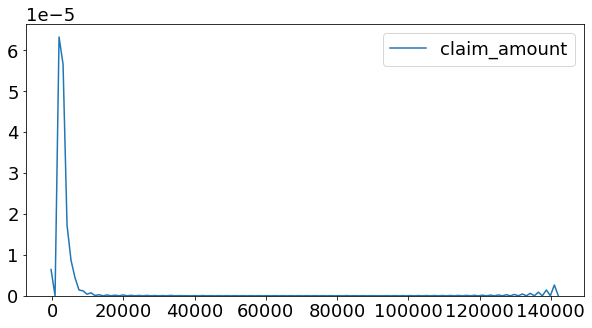

In [55]:
#plot severity
plt.figure(figsize = (10,5))
sns.kdeplot(y_train_sev)

In [56]:
#prepare datasets for lgb 
train_set_sev = lgb.Dataset(X_model_sev, y_model_sev)
val_set_sev = lgb.Dataset(X_val_sev, y_val_sev)

In [57]:
lgb_space_sev = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']),
    'objective': hp.choice('objective', ['regression', 'gamma']),
    'num_leaves': hp.choice('num_leaves', np.arange(30,150, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.choice('subsample_for_bin', np.arange(20000,300000, 20000, dtype = int)),
    'min_child_samples': hp.choice('min_child_samples', np.arange(20,500,5, dtype = int)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'seed': 42,
    'nthread': 10,
    'num_boost_round': 1000,
    'early_stopping_rounds': 20,
    'metric': 'rmse',
    'vebose_eval': 1
}

In [58]:
#run 100 models
#bayesian_opt(lgb_space_sev, 'lgb', train_set_sev, val_set_sev, 1000, 20, 42, 100, mode = 'sev', metric = 'rmse')

In [59]:
#continue gs
#bayesian_opt(lgb_space_sev, 'lgb', train_set_sev, val_set_sev, 1000, 20, 42, 10000, out_file='output/lgb_sev_trials.csv',
#             trials='output/lgb_sev_bayes_trials.pickle', mode = 'sev', metric = 'rmse')

In [60]:
bayes_params_sev = read_csv('output/lgb_sev_trials.csv')
print(f'We have {bayes_params_sev.shape[0]} models')
bayes_params_sev.head()

We have 10000 models


boosting_type colsample_bytree early_stopping_rounds learning_rate metric  \
0          gbdt         0.640138                    20      0.190784   rmse   
1          gbdt         0.626772                    20      0.190745   rmse   
2          gbdt         0.631924                    20      0.190741   rmse   
3          gbdt         0.630046                    20      0.190701   rmse   
4          gbdt         0.624581                    20      0.190627   rmse   

  min_child_samples nthread num_boost_round num_leaves   objective reg_alpha  \
0               430      10            1000        115  regression  0.745672   
1               430      10            1000         42  regression  0.922966   
2               430      10            1000        115  regression   0.65011   
3               430      10            1000         88  regression  0.747222   
4               430      10            1000        105  regression  0.669786   

  reg_lambda seed subsample subsample_for_bin vebose_eval         loss  \
0   0.998458   42  0.814893            200000           1  2492.670150   
1   0.979698   42  0.803887            120000           1  2492.670439   
2   0.983566   42  0.827092            220000           1  2492.670474   
3   0.948132   42  0.828499            220000           1  2492.670719   
4   0.970305   42  0.811896            220000           1  2492.671437   

   n_estimators  
0            19  
1            19  
2            19  
3            19  
4            19

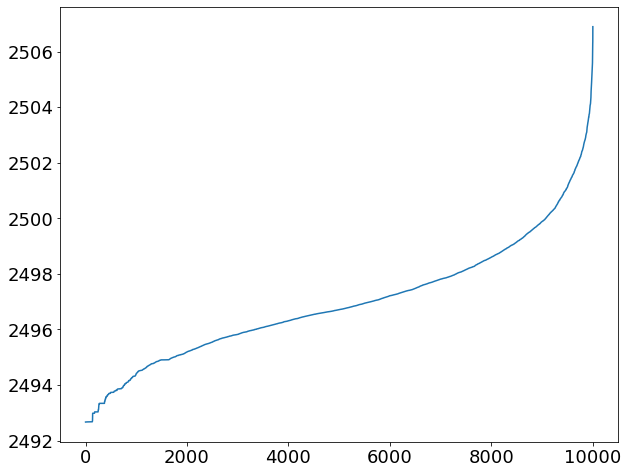

In [61]:
#plot the loss
plt.figure(figsize = (10,8)) 
plt.plot(bayes_params_sev['loss'])

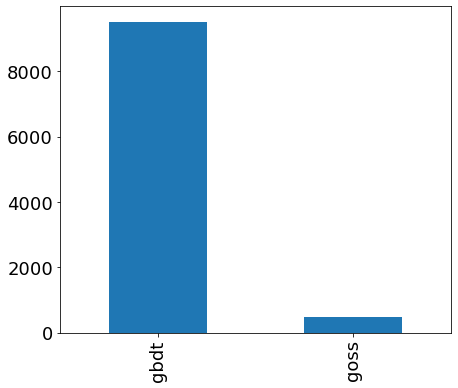

In [62]:
#plot boosting type
bayes_params_sev['boosting_type'].value_counts().plot.bar(figsize = (7,6))

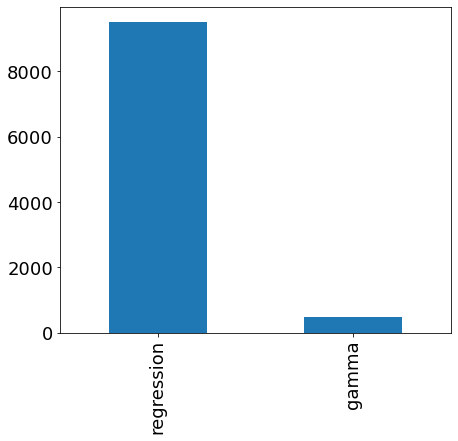

In [63]:
#plot objective
bayes_params_sev['objective'].value_counts().plot.bar(figsize = (7,6))

In [64]:
#evaluate best result
lgb_gs_sev = pd.read_csv('output/lgb_sev_trials.csv')
lgb_gs_sev.sort_values('loss', inplace = True)
lgb_gs_sev.reset_index(inplace = True, drop = True)

best_bayes_estimators_sev = lgb_gs_sev.loc[0, 'n_estimators']
best_bayes_params_sev = eval(lgb_gs_sev.loc[0,'params'])
best_bayes_params_sev['num_boost_round'] = best_bayes_estimators_sev

print(f"Use params {best_bayes_params_sev} \n")

#fit the best model on the whole train data
print("BEGIN TRAINING")
best_lgb_model_sev = lgb.train(params = best_bayes_params_sev, train_set=train_set_sev, 
                                valid_sets = [train_set_sev, val_set_sev])

Use params {'boosting_type': 'gbdt', 'colsample_bytree': 0.6401381424181951, 'early_stopping_rounds': 20, 'learning_rate': 0.19078390090455402, 'metric': 'rmse', 'min_child_samples': 430, 'nthread': 10, 'num_boost_round': 19, 'num_leaves': 115, 'objective': 'regression', 'reg_alpha': 0.7456724365790063, 'reg_lambda': 0.9984579189511087, 'seed': 42, 'subsample': 0.8148934017878723, 'subsample_for_bin': 200000, 'vebose_eval': 1} 

BEGIN TRAINING
[1]	training's rmse: 1831.53	valid_1's rmse: 2505.83
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 1827.49	valid_1's rmse: 2503.01
[3]	training's rmse: 1823.89	valid_1's rmse: 2500.79
[4]	training's rmse: 1821.56	valid_1's rmse: 2499.92
[5]	training's rmse: 1818.68	valid_1's rmse: 2498.94
[6]	training's rmse: 1816.34	valid_1's rmse: 2498.16
[7]	training's rmse: 1814.15	valid_1's rmse: 2497.05
[8]	training's rmse: 1812.05	valid_1's rmse: 2496.64
[9]	training's rmse: 1810.3	valid_1's rmse: 2496.09
[10]	training's

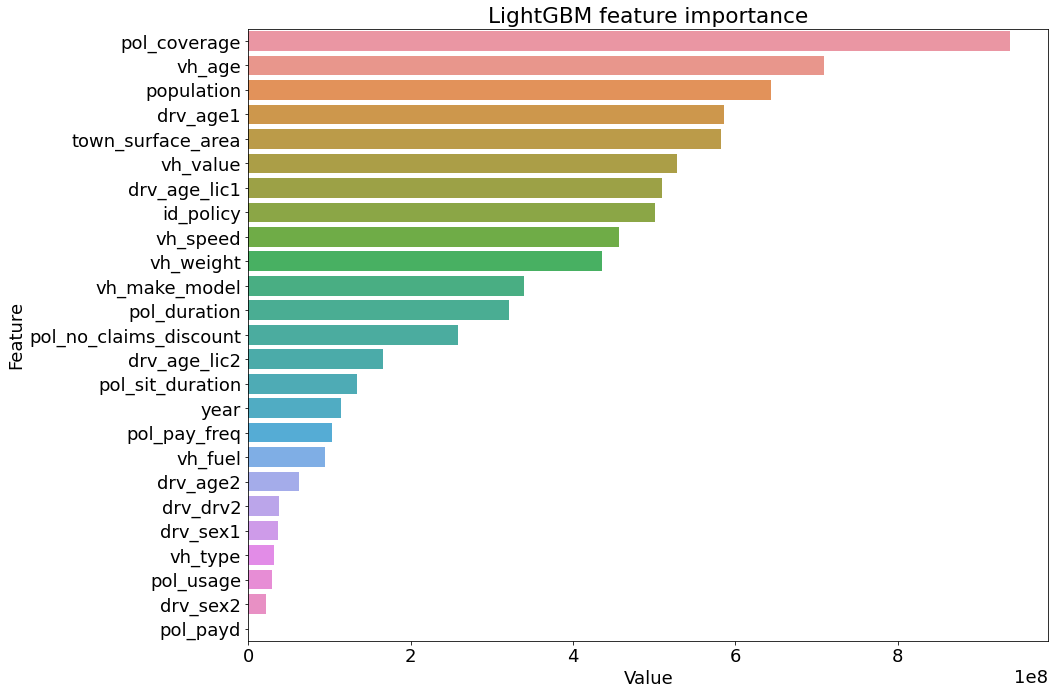

In [65]:
lgb_importance(best_lgb_model_sev, X_model_sev, 'gain', (15,10))

### Log severity model

In [66]:
y_train_sev_log = np.log1p(y_train_sev)
y_model_sev_log = np.log1p(y_model_sev)
y_val_sev_log = np.log1p(y_val_sev)

In [67]:
y_train_sev_log.describe()

count    23292.000000
mean         6.457237
std          1.134600
min          0.019803
25%          5.784709
50%          6.538899
75%          7.162235
max         11.862379
Name: claim_amount, dtype: float64

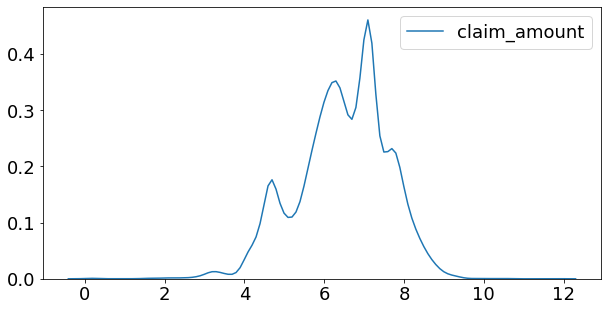

In [68]:
#plot severity
plt.figure(figsize = (10,5))
sns.kdeplot(y_train_sev_log)

In [69]:
#prepare datasets for lgb 
train_set_sev_log = lgb.Dataset(X_model_sev, y_model_sev_log)
val_set_sev_log = lgb.Dataset(X_val_sev, y_val_sev_log)

In [70]:
lgb_space_sev_log = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']),
    'objective': hp.choice('objective', ['regression', 'gamma']),
    'num_leaves': hp.choice('num_leaves', np.arange(30,150, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.choice('subsample_for_bin', np.arange(20000,300000, 20000, dtype = int)),
    'min_child_samples': hp.choice('min_child_samples', np.arange(20,500,5, dtype = int)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'seed': 42,
    'nthread': 10,
    'num_boost_round': 1000,
    'early_stopping_rounds': 20,
    'metric': 'rmse',
    'vebose_eval': 1
}

In [71]:
#run 100 models
#bayesian_opt(lgb_space_sev_log, 'lgb', train_set_sev_log, val_set_sev_log, 1000, 20, 42, 100, mode = 'sev_log', metric = 'rmse')

In [72]:
#continue gs
#bayesian_opt(lgb_space_sev_log, 'lgb', train_set_sev_log, val_set_sev_log, 1000, 20, 42, 10000, out_file='output/lgb_sev_log_trials.csv',
#             trials='output/lgb_sev_log_bayes_trials.pickle', mode = 'sev_log', metric = 'rmse')

In [73]:
bayes_params_sev_log = read_csv('output/lgb_sev_log_trials.csv')
print(f'We have {bayes_params_sev_log.shape[0]} models')
bayes_params_sev_log.head()

We have 10000 models


boosting_type colsample_bytree early_stopping_rounds learning_rate metric  \
0          gbdt         0.673603                    20     0.0240533   rmse   
1          gbdt         0.687305                    20      0.021217   rmse   
2          gbdt         0.678546                    20     0.0215727   rmse   
3          gbdt          0.68377                    20       0.02176   rmse   
4          gbdt         0.665316                    20     0.0219969   rmse   

  min_child_samples nthread num_boost_round num_leaves   objective  reg_alpha  \
0                55      10            1000         46  regression   0.227554   
1                55      10            1000         45  regression  0.0400813   
2                55      10            1000         46  regression   0.152127   
3                55      10            1000         45  regression   0.101136   
4                55      10            1000         45  regression   0.283845   

  reg_lambda seed subsample subsample_for_bin vebose_eval      loss  \
0   0.749883   42  0.746394            160000           1  1.085183   
1   0.904019   42  0.754643            120000           1  1.085200   
2   0.880998   42  0.722865            120000           1  1.085209   
3   0.903281   42  0.750972            120000           1  1.085261   
4   0.900866   42  0.701655            100000           1  1.085286   

   n_estimators  
0            95  
1           108  
2           109  
3           114  
4           116

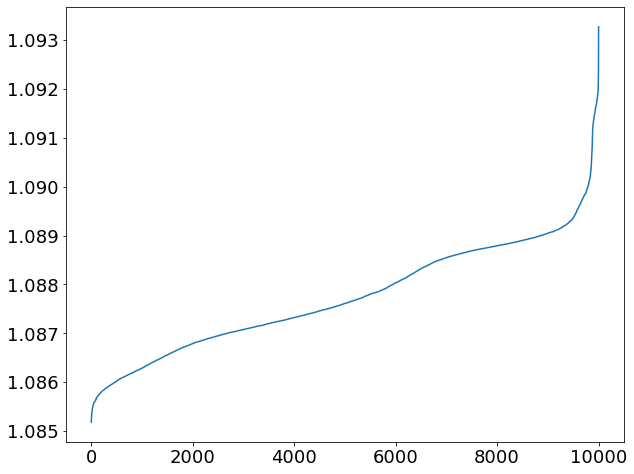

In [74]:
#plot the loss
plt.figure(figsize = (10,8)) 
plt.plot(bayes_params_sev_log['loss'])

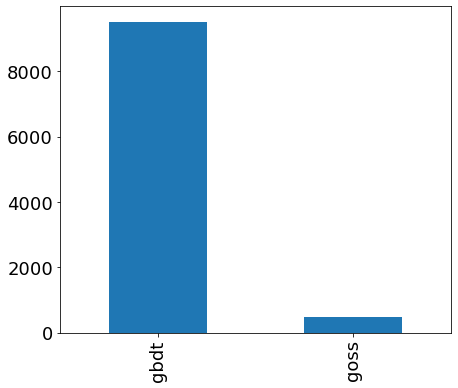

In [75]:
#plot boosting type
bayes_params_sev_log['boosting_type'].value_counts().plot.bar(figsize = (7,6))

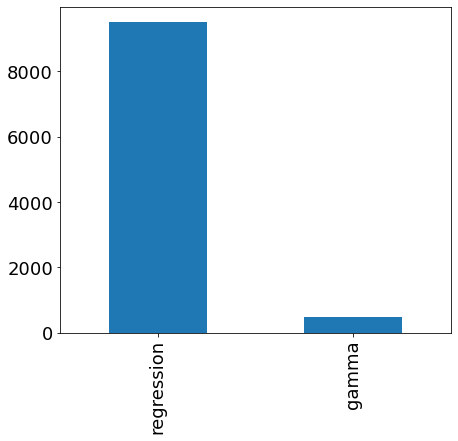

In [76]:
#plot objective
bayes_params_sev_log['objective'].value_counts().plot.bar(figsize = (7,6))

In [77]:
#evaluate best result
lgb_gs_sev_log = pd.read_csv('output/lgb_sev_log_trials.csv')
lgb_gs_sev_log.sort_values('loss', inplace = True)
lgb_gs_sev_log.reset_index(inplace = True, drop = True)

best_bayes_estimators_sev_log = lgb_gs_sev_log.loc[0, 'n_estimators']
best_bayes_params_sev_log = eval(lgb_gs_sev_log.loc[0,'params'])
best_bayes_params_sev_log['num_boost_round'] = best_bayes_estimators_sev_log

print(f"Use params {best_bayes_params_sev_log} \n")

#fit the best model on the whole train data
print("BEGIN TRAINING")
best_lgb_model_sev_log = lgb.train(params = best_bayes_params_sev_log, train_set=train_set_sev_log, 
                                valid_sets = [train_set_sev_log, val_set_sev_log])

Use params {'boosting_type': 'gbdt', 'colsample_bytree': 0.6736028617534354, 'early_stopping_rounds': 20, 'learning_rate': 0.024053331954133107, 'metric': 'rmse', 'min_child_samples': 55, 'nthread': 10, 'num_boost_round': 95, 'num_leaves': 46, 'objective': 'regression', 'reg_alpha': 0.22755372212733443, 'reg_lambda': 0.7498827244030459, 'seed': 42, 'subsample': 0.7463939319480145, 'subsample_for_bin': 160000, 'vebose_eval': 1} 

BEGIN TRAINING
[1]	training's rmse: 1.14237	valid_1's rmse: 1.10378
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 1.14115	valid_1's rmse: 1.10299
[3]	training's rmse: 1.14001	valid_1's rmse: 1.1022
[4]	training's rmse: 1.13911	valid_1's rmse: 1.10182
[5]	training's rmse: 1.13791	valid_1's rmse: 1.10107
[6]	training's rmse: 1.13703	valid_1's rmse: 1.10068
[7]	training's rmse: 1.13589	valid_1's rmse: 1.09996
[8]	training's rmse: 1.13489	valid_1's rmse: 1.09937
[9]	training's rmse: 1.1339	valid_1's rmse: 1.09891
[10]	training's 

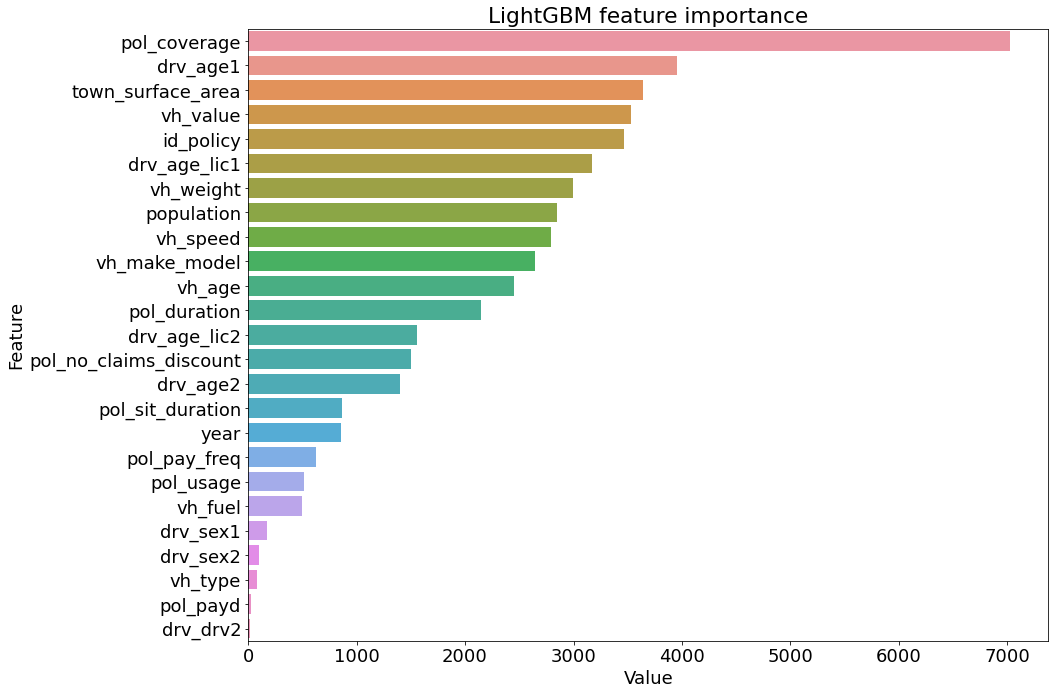

In [78]:
lgb_importance(best_lgb_model_sev_log, X_model_sev, 'gain', (15,10))

In [79]:
pred_sev_val_exp = np.expm1(best_lgb_model_sev_log.predict(X_val_sev))
print(f"The validation rmse is {np.sqrt(mean_squared_error(pred_sev_val_exp, y_val_sev))}")

The validation rmse is 2550.2302942821916


### Combine freq x sev

In [80]:
pred_freq_val = best_lgb_model_freq.predict(X_val)
pred_sev_val = best_lgb_model_sev.predict(X_val)
pred_val = pred_freq_val * pred_sev_val

In [81]:
print(f"The validation rmse is {np.sqrt(mean_squared_error(pred_val, y_val))}")

The validation rmse is 826.9563635739894


In [82]:
#test the first 20 models 
num_models = 0
val_metrics = []
for i in range(num_models):
    
    #freq
    best_bayes_estimators_freq_i = lgb_gs_freq.loc[i, 'n_estimators']
    best_bayes_params_freq_i = eval(lgb_gs_freq.loc[i,'params'])
    best_bayes_params_freq_i['num_boost_round'] = best_bayes_estimators_freq_i

    #fit the best model on the whole train data
    lgb_model_freq_i = lgb.train(params = best_bayes_params_freq_i, train_set=train_set_freq, 
                                    valid_sets = [train_set_freq, val_set_freq], verbose_eval=-1)
    
    pred_freq_val_i = lgb_model_freq_i.predict(X_val)
    
    #sev
    best_bayes_estimators_sev_i = lgb_gs_sev.loc[i, 'n_estimators']
    best_bayes_params_sev_i = eval(lgb_gs_sev.loc[i,'params'])
    best_bayes_params_sev_i['num_boost_round'] = best_bayes_estimators_sev_i

    #fit the best model on the whole train data
    lgb_model_sev_i = lgb.train(params = best_bayes_params_sev_i, train_set=train_set_sev, 
                                    valid_sets = [train_set_sev, val_set_sev], verbose_eval = -1)
    
    print(f'Finish model {i}')
    
    pred_sev_val_i = lgb_model_sev_i.predict(X_val)
    
    pred_val_i = pred_freq_val_i * pred_sev_val_i
    
    val_metrics.append(np.sqrt(mean_squared_error(y_val, pred_val_i)))

results = pd.DataFrame({'Id': range(num_models), 'val_metrics': val_metrics})

In [83]:
results

Empty DataFrame
Columns: [Id, val_metrics]
Index: []

### Combine freq x sev_log

In [84]:
pred_freq_val = best_lgb_model_freq.predict(X_val)
pred_sev_val_exp = np.expm1(best_lgb_model_sev_log.predict(X_val))
pred_val_exp = pred_freq_val * pred_sev_val_exp

In [85]:
print(f"The validation rmse is {np.sqrt(mean_squared_error(pred_val_exp, y_val))}")

The validation rmse is 828.9121098305174


In [86]:
#test the first 20 models 
num_models = 0
val_metrics = []
for i in range(num_models):
    
    #freq
    best_bayes_estimators_freq_i = lgb_gs_freq.loc[i, 'n_estimators']
    best_bayes_params_freq_i = eval(lgb_gs_freq.loc[i,'params'])
    best_bayes_params_freq_i['num_boost_round'] = best_bayes_estimators_freq_i

    #fit the best model on the whole train data
    lgb_model_freq_i = lgb.train(params = best_bayes_params_freq_i, train_set=train_set_freq, 
                                    valid_sets = [train_set_freq, val_set_freq], verbose_eval=-1)
    
    pred_freq_val_i = lgb_model_freq_i.predict(X_val)
    
    #sev
    best_bayes_estimators_sev_log_i = lgb_gs_sev_log.loc[i, 'n_estimators']
    best_bayes_params_sev_log_i = eval(lgb_gs_sev_log.loc[i,'params'])
    best_bayes_params_sev_log_i['num_boost_round'] = best_bayes_estimators_sev_log_i

    #fit the best model on the whole train data
    lgb_model_sev_log_i = lgb.train(params = best_bayes_params_sev_log_i, train_set=train_set_sev_log, 
                                    valid_sets = [train_set_sev_log, val_set_sev_log], verbose_eval = -1)
    
    print(f'Finish model {i}')
    
    pred_sev_val_log_i = np.expm1(lgb_model_sev_log_i.predict(X_val))
    
    pred_val_log_i = pred_freq_val_i * pred_sev_val_log_i
    
    val_metrics.append(np.sqrt(mean_squared_error(y_val, pred_val_log_i)))

results = pd.DataFrame({'Id': range(num_models), 'val_metrics': val_metrics})

In [87]:
results

Empty DataFrame
Columns: [Id, val_metrics]
Index: []

### Stacking

#### Create OOT pred for xgb and lgb

In [88]:
best_bayes_params = {
    'boosting_type': 'goss',
     'colsample_bytree': 0.6172740422553246,
     'learning_rate': 0.15595728874144082,
     'metric': 'rmse',
     'min_child_samples': 430,
     'nthread': 10,
     'num_boost_round': 36,
     'num_leaves': 45,
     'objective': 'tweedie',
     'reg_alpha': 0.8499119497868239,
     'reg_lambda': 0.5860052343438305,
     'seed': 42,
     'subsample': 0.8339240170542691,
     'subsample_for_bin': 220000,
     'vebose_eval': -1
}

In [89]:
#OOF predictions
oof_preds_lgb = []
yrs = X_clean['year'].unique()

#add the first year
print(f"Compute oof pred for year 1.0")
X_1 = X_clean[X_clean['year'] == 1].reset_index(drop=True)
y_1 = df.loc[df['year'] == 1, 'claim_amount'].reset_index(drop=True)
train_set_1 = lgb.Dataset(X_1, y_1)
lgb_model_1 = lgb.train(params = best_bayes_params, train_set=train_set_1)
oof_preds_lgb.append(lgb_model_1.predict(X_1))

for yr in yrs[1:]:
    print(f"Compute oof pred for year {yr}")
    X_i = X_clean[X_clean['year']<yr].reset_index(drop=True)
    y_i = df.loc[df['year']<yr, 'claim_amount'].reset_index(drop=True)
    X_i_next = X_clean[X_clean['year'] == yr].reset_index(drop = True)
    train_set_i = lgb.Dataset(X_i, y_i)
    lgb_model_i = lgb.train(params = best_bayes_params, train_set=train_set_i)
    oof_preds_lgb.append(lgb_model_i.predict(X_i_next))

Compute oof pred for year 1.0
Compute oof pred for year 2.0
Compute oof pred for year 3.0
Compute oof pred for year 4.0


In [90]:
#concatenate vertically
oof_preds_lgb_model = np.concatenate(oof_preds_lgb[:-1], axis = 0)
oof_preds_lgb_val = oof_preds_lgb[-1]
print(f"length of oof preds for modelling is {len(oof_preds_lgb_model)}")
print(f"length of oof preds for validation is {len(oof_preds_lgb_val)}")

length of oof preds for modelling is 171162
length of oof preds for validation is 57054


In [91]:
best_bayes_params_xgb = {
    'colsample_bytree': 0.7326323266013696,
     'eval_metric': 'rmse',
     'gamma': 0.6364878999736042,
     'learning_rate': 0.04955834926839291,
     'max_depth': 4,
     'min_child_weight': 470,
     'nthread': 13,
     'objective': 'reg:tweedie',
     'reg_alpha': 0.9150383999448207,
     'reg_lambda': 0.4158916305804351,
     'seed': 42,
     'subsample': 0.5304963105566902,
     'verbose_eval': 0,
     'num_boost_round': 230
}

In [92]:
#OOF predictions
oof_preds_xgb = []
yrs = X_clean['year'].unique()

#add the first year
print(f"Compute oof pred for year 1.0")
X_1 = X_clean[X_clean['year'] == 1].reset_index(drop=True)
y_1 = df.loc[df['year'] == 1, 'claim_amount'].reset_index(drop=True)
train_set_1_xgb = xgb.DMatrix(X_1, y_1)
xgb_model_1 = xgb.train(best_bayes_params_xgb, train_set_1_xgb, num_boost_round = best_bayes_params_xgb['num_boost_round'], verbose_eval = False)
oof_preds_xgb.append(xgb_model_1.predict(xgb.DMatrix(X_1)))

for yr in yrs[1:]:
    print(f"Compute oof pred for year {yr}")
    X_i = X_clean[X_clean['year']<yr].reset_index(drop=True)
    y_i = df.loc[df['year']<yr, 'claim_amount'].reset_index(drop=True)
    X_i_next = X_clean[X_clean['year'] == yr].reset_index(drop = True)
    train_set_i_xgb = xgb.DMatrix(X_i, y_i)
    xgb_model_i = xgb.train(best_bayes_params_xgb, train_set_i_xgb, num_boost_round = best_bayes_params_xgb['num_boost_round'], verbose_eval = False)
    oof_preds_xgb.append(xgb_model_i.predict(xgb.DMatrix(X_i_next)))

Compute oof pred for year 1.0
[08:32:17] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_boost_round, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Compute oof pred for year 2.0
[08:32:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_boost_round, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Compute oof pred for year 3.0
[08:32:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_boost_round, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bi

In [93]:
#concatenate vertically
oof_preds_xgb_model = np.concatenate(oof_preds_xgb[:-1], axis = 0)
oof_preds_xgb_val = oof_preds_xgb[-1]
print(f"length of oof preds for modelling is {len(oof_preds_xgb_model)}")
print(f"length of oof preds for validation is {len(oof_preds_xgb_val)}")

length of oof preds for modelling is 171162
length of oof preds for validation is 57054


#### Obtain the L0 data

In [94]:
L0_model = pd.DataFrame({'lgb': oof_preds_lgb_model, 'xgb': oof_preds_xgb_model})
L0_val = pd.DataFrame({'lgb': oof_preds_lgb_val, 'xgb': oof_preds_xgb_val})
print(f"Shape of L0 data for modelling is {L0_model.shape}")
print(f"Shape of L0 data for validation is {L0_val.shape}")

Shape of L0 data for modelling is (171162, 2)
Shape of L0 data for validation is (57054, 2)


In [95]:
L1_model = ElasticNet() #LinearRegression()
L1_model.fit(L0_model, y_model)
print(f"Coefs of lnear stacking models are {L1_model.coef_}")

Coefs of lnear stacking models are [-3.12264996  5.31460559]


In [96]:
L1_preds = L1_model.predict(L0_val)
print(f"The rmse of stacking model is {np.sqrt(mean_squared_error(L1_preds, y_val))}")

The rmse of stacking model is 835.1495303407407
